# apply instruments settings

In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config as hdc

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# connect to devices
pg  = PulseGenerator(ip=hdc.PS_IP, chmap=hdc.PS_chmap) 
mwsyn = Synthesizer(hdc.VDISYN_SN, 
                    vidpid=hdc.VDISYN_VIDPID,
                    baudrate=hdc.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hdc.LASER_SN)
laser.open()
# mwsyn.close()
# laser.close()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [3]:
current_percent = 90.05
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [888]:
# laserpower = 145.0
# laser.laser_off()
# laser.set_analog_control_mode("power")
# laser.set_modulation_state("CW")
# laser.set_laser_power(laserpower, save_memory=False)
# laser.laser_on()

In [24]:
NI_ratebase = 100.00/1E3 # GHz
NI_timebase = 1.0/NI_ratebase #ns
laser_init = 6400
wait_init = 800
mw_dur_start = 0.0
mw_dur_stop = 3200
mw_dur_step = 80
mw_dur = np.arange(mw_dur_start, mw_dur_stop+mw_dur_step, mw_dur_step)
# mw_dur = np.geomspace(mw_dur_start, mw_dur_stop, 320, endpoint=True)
# rounding is IMPORTANT!!
# mw_dur = np.round(NI_ratebase*mw_dur)*NI_timebase # round to DAQ timebase
mw_dur = np.round(mw_dur) # round to PS timebase
mw_dur_stop = mw_dur[-1]
mw_dur_start = mw_dur[0]
wait_read = 300
laser_read = 800

# here is to fix the timing
totaltime_max = laser_init+wait_init+mw_dur_stop+wait_read+laser_read
tbmultiple = int(NI_ratebase*totaltime_max+1)
sampling_rate = NI_ratebase/tbmultiple
sampletime = round(1.0/sampling_rate)
samplerate = 1.0/sampletime #GHz
padding_fix = sampletime-totaltime_max
padding = padding_fix+mw_dur_stop-mw_dur # depends on MW duration
num_pt = len(mw_dur)

assert np.all(padding+mw_dur+laser_init+wait_init+wait_read+laser_read == sampletime)
assert padding_fix >= 0


In [25]:
delaydiff = NI_timebase*15.0
readoffset = NI_timebase*25.0
daqpadding = sampletime - (laser_read - readoffset - delaydiff)
daqpadding = int(NI_ratebase*daqpadding)/NI_ratebase
daqdelay = 0.0
daqtriggerdelay = NI_timebase*0.0


seq_daqtrig = [(daqdelay, LOW)] + [(daqtriggerdelay, LOW)] + [(daqpadding-NI_ratebase*10, LOW)] + [(sampletime, HIGH), (sampletime*(num_pt*2 - 1) - daqtriggerdelay-daqpadding+NI_ratebase*10, LOW)]
seq_clock = [(daqdelay, LOW)] + [(daqpadding, LOW),(sampletime-daqpadding, HIGH)]*num_pt*2

seq_laser = []
seq_mwA = []
seq_mwB = []
skip = 0
seq_laser_sub_alloff = [(padding[-1], LOW), (laser_init, LOW), (wait_init, LOW), (mw_dur[-1], LOW), (wait_read, LOW), (laser_read, LOW)]
# for mwd, pd in zip(mw_dur, padding):
for ii in range(len(mw_dur)-skip):
    mwd = mw_dur[ii]
    pd = padding[ii]
    seq_laser_sub = [(pd, LOW), (laser_init, HIGH), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH)]
    seq_mwA_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW)]
    seq_mwA_noMW_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW)]

    seq_laser += seq_laser_sub + seq_laser_sub
    seq_mwA += seq_mwA_sub + seq_mwA_noMW_sub
    seq_mwB += seq_mwA_noMW_sub + seq_mwA_noMW_sub

seq_laser += (seq_laser_sub_alloff + seq_laser_sub_alloff)*skip
seq_mwA += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_mwB += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_laser +=  [(daqdelay, LOW)]
seq_mwA +=  [(daqdelay, LOW)]
seq_mwB +=  [(daqdelay, LOW)]


rrr = 8
pg.setDigital("laser", seq_laser*rrr)
pg.setDigital("mw_A", seq_mwA*rrr)
pg.setDigital("mw_B", seq_mwB*rrr)
pg.setDigital("daqtrig", seq_daqtrig*rrr)
pg.setDigital("clock", seq_clock*rrr)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
assert round(np.sum(np.array(seq_laser)[:, 0])) == round(np.sum(np.array(seq_mwA)[:, 0])) == round(np.sum(np.array(seq_daqtrig)[:, 0])) == round(np.sum(np.array(seq_clock)[:, 0]))
assert sampletime > daqpadding + 10

In [26]:
aa = np.sum(np.array(seq_laser)[:, 0])
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_mwA)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_daqtrig)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_clock)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")

Total Seq. Time: 943820.0ns
Total Seq. Time: 943820.0ns
Total Seq. Time: 943820.0ns
Total Seq. Time: 943820.0ns


In [28]:
# signal reading parameters
min_volt = -0.001 # [V]
max_volt = 0.003
samplerate_read = samplerate*1E9 # 500kHz .max ext clock rate of NI6343, check it by yourself!
num_readsample = num_pt*2
timeout_read = max(2*num_readsample/samplerate_read, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hdc.NI_ch_APD,"",
            # TerminalConfiguration.RSE,
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
# readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
readtask.timing.cfg_samp_clk_timing(
    samplerate_read, 
    source=hdc.NI_ch_Clock, 
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS, 
    # sample_mode=AcquisitionType.FINITE, 
    samps_per_chan=num_readsample)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hdc.NI_ch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True

In [27]:
readtask.close()

# Start measurement


In [29]:
laser.laser_on() # turn on laser
pg.stream(n_runs=INF)
pg.startNow()

0

In [239]:
f_NVguess = 398.5567714869976
f_NVguess = 392.8397714495659
freq_start = (f_NVguess-0.010)/24.0
freq_stop = (f_NVguess+0.010)/24.0
# check the minium step size
freqminstep_list = mwsyn.get_min_step_size([freq_start], [freq_stop])
step_min = freqminstep_list[0] # in Hz
freq_step = 0.1E-3/24.0
freq_step = int(freq_step/step_min*1E9)*step_min/1E9
freq_array = np.arange(freq_start, freq_stop, freq_step)
num_freq = len(freq_array)
freq_actual = np.zeros(num_freq)

signal = np.zeros(num_freq)
background = np.zeros(num_freq)
# repeat measurement
num_repeat_freq = 2
readdur_mwt = 4  # read data for ? seconds for each frequency point


numrepeat_array_av = np.zeros(num_freq)
signal_array_av = np.zeros((num_freq, num_pt))
background_array_av = np.zeros((num_freq, num_pt))
contrast_array_av = np.zeros((num_freq, num_pt))
for kkk in range(num_repeat_freq):
    numrepeat_array = np.zeros(num_freq)
    signal_array = np.zeros((num_freq, num_pt))
    background_array = np.zeros((num_freq, num_pt))
    contrast_array = np.zeros((num_freq, num_pt))
    for (jj, ff) in enumerate(freq_array):
        errorbyte, freq_actual[jj] = mwsyn.cw_frequency(ff)
        num_repeat_mwt = 0
        signal_av = np.zeros(num_pt)
        background_av = np.zeros(num_pt)
        readtask.start() # ready to read data
        start_time = time.time()
        while time.time() - start_time < readdur_mwt:
            num_read = reader.read_many_sample(
                    buffer_readpoint,
                    num_readsample,
                    timeout_read
                )
            signal_av += np.copy(buffer_readpoint[0::2])
            background_av += np.copy(buffer_readpoint[1::2])
            num_repeat_mwt += 1
        numrepeat_array[jj] = num_repeat_mwt
        signal_array[jj] = signal_av/num_repeat_mwt
        background_array[jj] = background_av/num_repeat_mwt
        contrast_array[jj] = (signal_av-background_av)/background_av
        readtask.stop() # stop to read data
    numrepeat_array_av += numrepeat_array
    signal_array_av += signal_array
    background_array_av += background_array
    contrast_array_av += contrast_array

signal_array_av = signal_array_av/num_repeat_freq
background_array_av = background_array_av/num_repeat_freq
contrast_array_av = contrast_array_av/num_repeat_freq
# laser.laser_off()
# readtask.close()

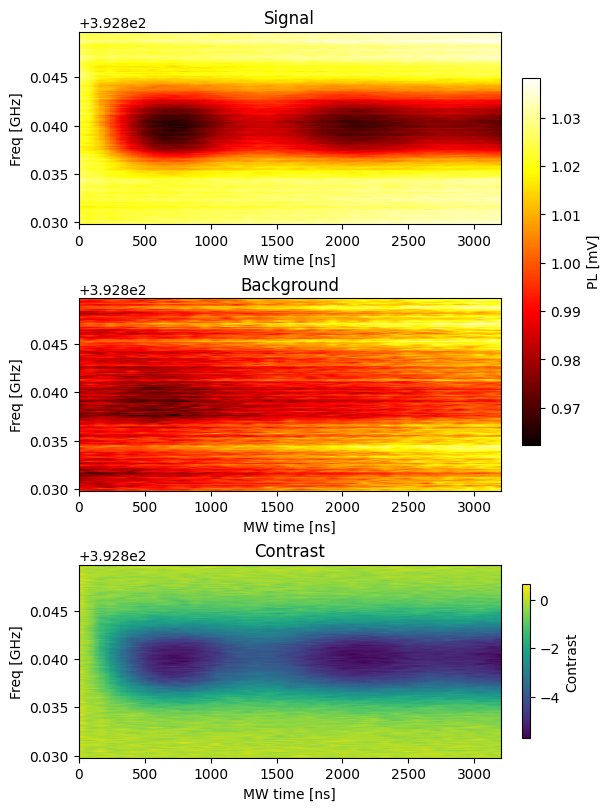

In [240]:
fig, axs = plt.subplots(3, 1, layout='constrained', figsize=(6, 8))
ims = []

im1 = axs[0].pcolormesh(mw_dur, freq_actual * 24, signal_array_av*1E3, cmap='hot', shading='gouraud')
axs[0].set_title('Signal')
axs[0].set_xlabel('MW time [ns]')
axs[0].set_ylabel(f'Freq [GHz]')
ims.append(im1)

im2 = axs[1].pcolormesh(mw_dur, freq_actual * 24, background_array_av*1E3, cmap='hot', shading='gouraud')
axs[1].set_title('Background')
axs[1].set_xlabel('MW time [ns]')
axs[1].set_ylabel(f'Freq [GHz]')
ims.append(im2)

im3 = axs[2].pcolormesh(mw_dur, freq_actual * 24, contrast_array_av*1E2, shading='gouraud')
axs[2].set_title('Contrast')
axs[2].set_xlabel('MW time [ns]')
axs[2].set_ylabel(f'Freq [GHz]')
ims.append(im2)

# Add a single colorbar
cbar1 = fig.colorbar(im1, ax=axs[:2], shrink=0.8)
cbar1.set_label('PL [mV]')
cbar2 = fig.colorbar(im3, ax=axs[-1], shrink=0.8)
cbar2.set_label('Contrast')

plt.show()

In [ ]:
# to save file


In [906]:
np.savetxt('output\\20240507_pulsedodmrrabi\\m1odmrrabi.txt', np.c_[mw_dur, signal_av, background_av])

In [241]:
pg.constant(OutputState.ZERO())
laser.laser_off() # turn off laser
readtask.close()
# mwsyn.reboot()

In [842]:
mwsyn.reboot()

MW Synthesizer Rebooted!


In [242]:
# close the communication
laser.close()
mwsyn.close()


In [243]:
pg.reset()